In [1]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import configparser
import warnings
warnings.filterwarnings('ignore')

In [2]:
def fetch_data():
    config = configparser.ConfigParser()
    config.read('db_config.ini')

    host = config['database']['host']
    port = config['database'].getint('port')
    user = config['database']['user']
    password = config['database']['password']
    database = config['database']['database']

    connection = psycopg2.connect(
        host=host,
        port=port,
        user=user,
        password=password,
        database=database
    )

    df1 = pd.read_sql('SELECT * FROM turbofan_engine_data', con=connection)
    df2 = pd.read_sql('SELECT * FROM turbofan_rul_data', con=connection)

    connection.close()

    return df1, df2

In [3]:
df1, df2 = fetch_data()

In [4]:
def clean_data(df):
    # Handling missing values
    na_counts_before = df.isna().sum()
    if na_counts_before.sum() > 0:
        print(f"Rows with missing values before: {na_counts_before.sum()}")
        df = df.dropna(axis=0)
        na_counts_after = df.isna().sum()
        print(f"Rows with missing values after: {na_counts_after.sum()}")
    else:
        print("No missing values found. Proceeding with the original DataFrame.")

    # Handling duplicates
    duplicates_before = df[df.duplicated(keep='first')]
    if len(duplicates_before) > 0:
        print(f"Duplicates before: {len(duplicates_before)}")
        df = df.drop_duplicates(keep='first')
        duplicates_after = df[df.duplicated(keep='first')]
        print(f"Duplicates after: {len(duplicates_after)}")
    else:
        print("No duplicate rows found. Proceeding with the original DataFrame.")

    return df

In [5]:
df1 = clean_data(df1)
df2 = clean_data(df2)

No missing values found. Proceeding with the original DataFrame.
No duplicate rows found. Proceeding with the original DataFrame.
No missing values found. Proceeding with the original DataFrame.
No duplicate rows found. Proceeding with the original DataFrame.


In [6]:
train_df = df1[df1["source"] == 0].copy()
test_df = df1[df1["source"] == 1].copy()

# **Deriving RUL Column**

In [7]:
def add_rul_train(df):
    max_cycles_train = df.groupby('engine')['cycle'].max().reset_index()
    max_cycles_train.columns = ['engine', 'max_cycle_train']
    df = df.merge(max_cycles_train, on='engine', how='left')
    df['RUL'] = df['max_cycle_train'] - df['cycle']
    df.drop(['max_cycle_train'], axis=1, inplace=True)
    return df

In [8]:
def add_rul_test(df, external_rul_df):
    df = df.merge(external_rul_df[['engine', 'RUL']], on='engine', how='left')
    return df

In [9]:
train_df_with_rul = add_rul_train(train_df)
test_df_with_rul = add_rul_test(test_df, df2)

In [10]:
relevant_cols = ['LPC_outlet_temperature (T24)', 'HPC_outlet_temperature (T30)',
                 'LPT_outlet_temperature (T50)', 'fan_inlet_pressure (P2)',
                 'bypass_duct_pressure (P15)', 'fan_speed (Nf)', 'core_speed (Nc)',
                 'HPC_outlet_static_pressure (Ps30)', 'altitude (alt)', 'mach_number (mach)',
                 'throttle_resolver_angle (TRA)', 'fan_inlet_temperature (T2)',
                 'HPC_outlet_pressure (P30)', 'engine_pressure_ratio (epr)',
                 'fuel_ps30_ratio (phi)', 'corrected_fan_speed (NRf)', 'corrected_core_speed (NRc)',
                 'bypass_ratio (BPR)', 'burner_fuel_air_ratio (farB)', 'bleed_enthalpy (htBleed)',
                 'demanded_fan_speed (Nf_dmd)', 'demanded_corrected_fan_speed (PCNfR_dmd)',
                 'HPT_coolant_bleed (W31)', 'LPT_coolant_bleed (W32)']

In [11]:
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    rmse = int(np.sqrt(mean_squared_error(y, y_pred)))
    mae = int(mean_absolute_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return rmse, mae, round(r2, 4)

In [12]:
def plot_boxplots(df, columns, title_suffix):
    fig, axes = plt.subplots(nrows=len(columns), figsize=(10, 3*len(columns)))
    fig.suptitle(f'Distribution Comparison {title_suffix}', fontsize=16)
    fig.subplots_adjust(top=0.95, hspace=0.5)

    for i, col in enumerate(columns):
        sns.boxplot(ax=axes[i], x=df[col], orient='h')
        axes[i].set_title(f'{col}')

    plt.tight_layout()
    plt.show()

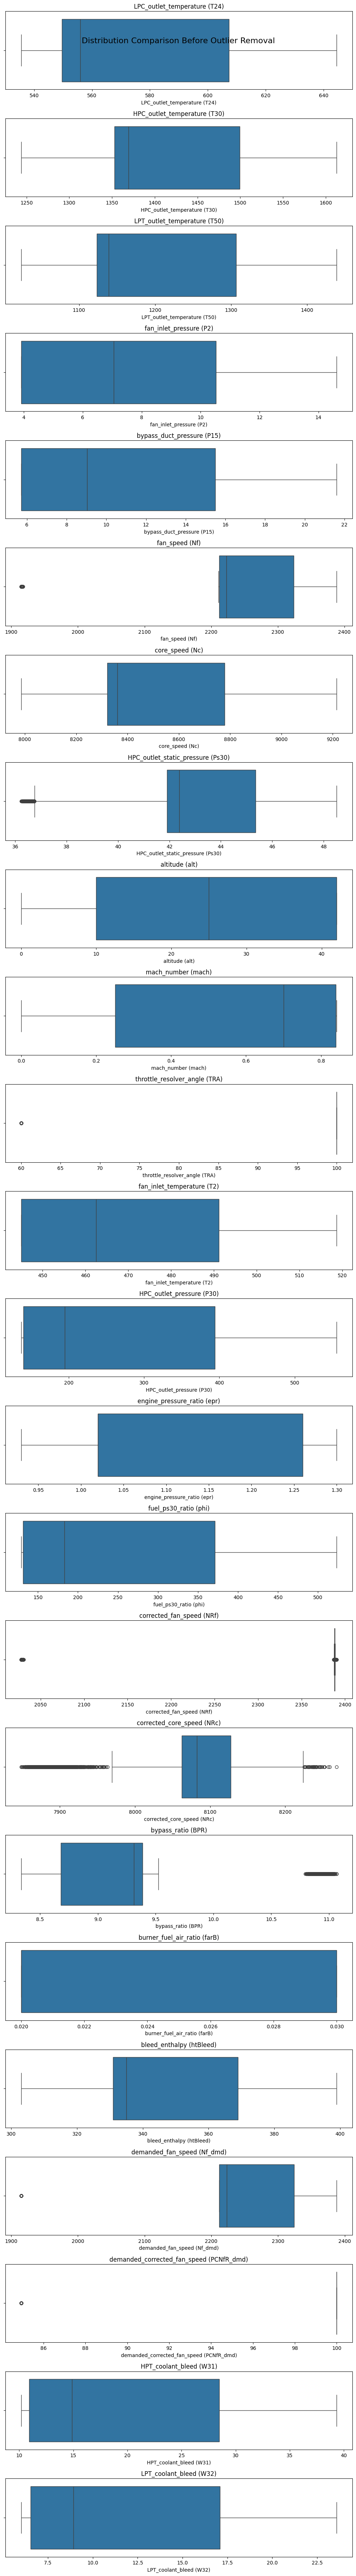

In [13]:
plot_boxplots(train_df_with_rul, relevant_cols, 'Before Outlier Removal')

# **Removing Outliers based on Z-score**

In [14]:
def remove_outliers_zscore(df, columns, threshold=2.0):
    z_scores = np.abs((df[columns] - df[columns].mean()) / df[columns].std())
    df_clean = df[(z_scores < threshold).all(axis=1)]
    print(f"Removed {len(df) - len(df_clean)} outliers using Z-score method.")
    return df_clean

In [15]:
train_df_clean_zscore = remove_outliers_zscore(train_df_with_rul, relevant_cols)
test_df_clean_zscore = remove_outliers_zscore(test_df_with_rul, relevant_cols)

Removed 8035 outliers using Z-score method.
Removed 5045 outliers using Z-score method.


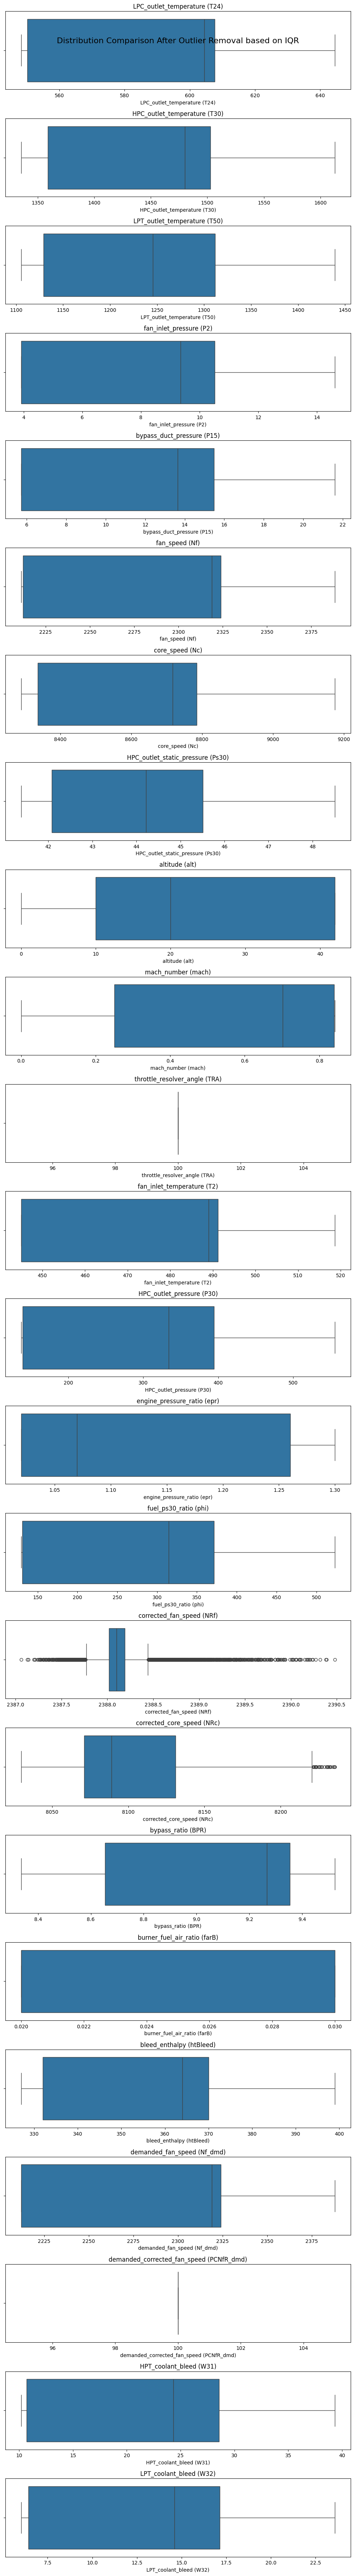

In [16]:
plot_boxplots(train_df_clean_zscore, relevant_cols, 'After Outlier Removal based on IQR')

In [17]:
test_last_cycle = test_df_clean_zscore.groupby('engine')['cycle'].idxmax()
test_last_cycle_df = test_df_clean_zscore.loc[test_last_cycle]

In [18]:
X_train = train_df_clean_zscore[relevant_cols]
X_test = test_last_cycle_df[relevant_cols]

In [19]:
y_train = train_df_clean_zscore['RUL']
y_test = test_last_cycle_df['RUL']

In [20]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Model Training**


In [21]:
model_selected_lr = LinearRegression()
model_selected_lr.fit(X_train_scaled, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_selected_lr, X_train_scaled, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_selected_lr, X_test_scaled, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 44, Train MAE: 34, Train R²: 0.5789
Test RMSE: 34, Test MAE: 27, Test R²: 0.5929


In [22]:
model_selected_svr = SVR()
model_selected_svr.fit(X_train_scaled, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_selected_svr, X_train_scaled, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_selected_svr, X_test_scaled, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 55, Train MAE: 42, Train R²: 0.3536
Test RMSE: 39, Test MAE: 31, Test R²: 0.4669


In [23]:
model_selected_rf = RandomForestRegressor()
model_selected_rf.fit(X_train_scaled, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_selected_rf, X_train_scaled, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_selected_rf,X_test_scaled, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 16, Train MAE: 11, Train R²: 0.9457
Test RMSE: 32, Test MAE: 23, Test R²: 0.6382


In [24]:
model_selected_xgb = XGBRegressor()
model_selected_xgb.fit(X_train_scaled, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_selected_xgb, X_train_scaled, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_selected_xgb, X_test_scaled, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 36, Train MAE: 26, Train R²: 0.7304
Test RMSE: 33, Test MAE: 24, Test R²: 0.6027


# **Removing Outliers based on IQR**

In [25]:
def remove_outliers_iqr(df, columns):
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    is_outlier = ((df[columns] < (Q1 - 1.5 * IQR)) | (df[columns] > (Q3 + 1.5 * IQR)))
    df_clean = df[~is_outlier.any(axis=1)]
    print(f"Removed {len(df) - len(df_clean)} outliers.")
    return df_clean

In [26]:
train_df_clean = remove_outliers_iqr(train_df_with_rul, relevant_cols)
test_df_clean = remove_outliers_iqr(test_df_with_rul, relevant_cols)

Removed 9692 outliers.
Removed 5486 outliers.


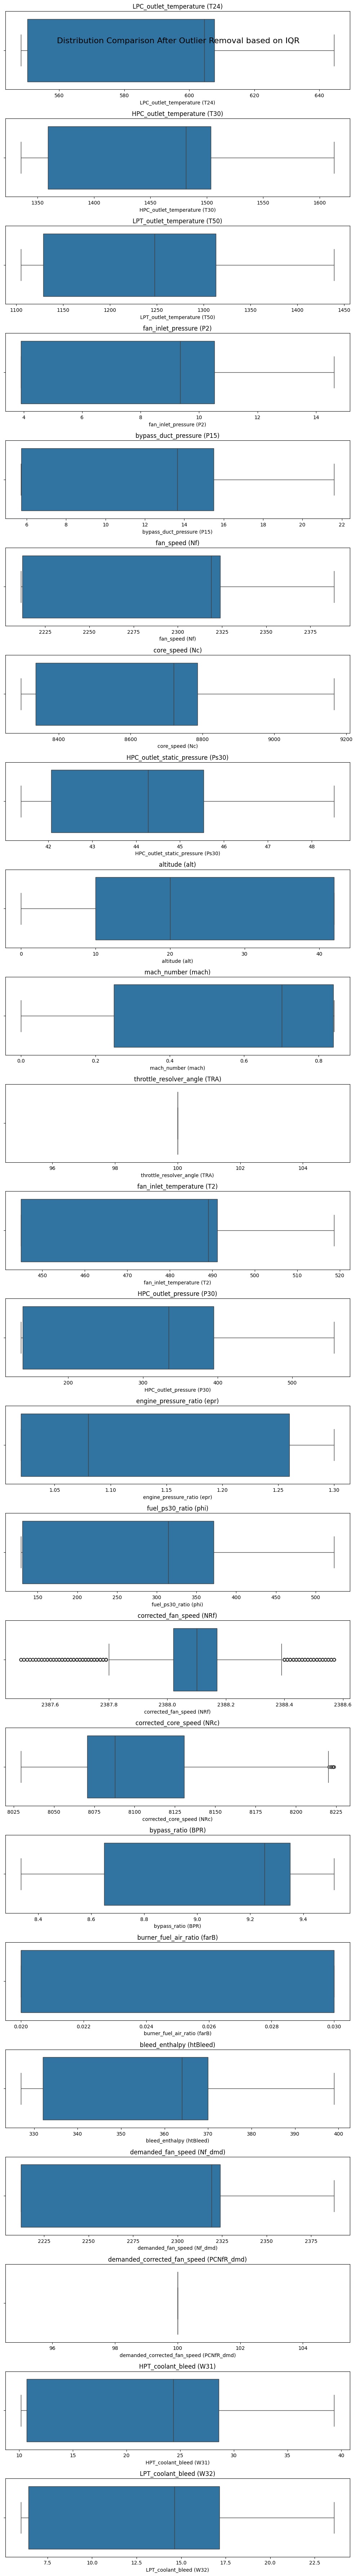

In [27]:
plot_boxplots(train_df_clean, relevant_cols, 'After Outlier Removal based on IQR')

In [28]:
test_last_cycle = test_df_clean.groupby('engine')['cycle'].idxmax()
test_last_cycle_df = test_df_clean.loc[test_last_cycle]

In [29]:
X_train = train_df_clean[relevant_cols]
X_test = test_last_cycle_df[relevant_cols]

In [30]:
y_train = train_df_clean['RUL']
y_test = test_last_cycle_df['RUL']

In [31]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# **Model Training**

In [32]:
model_selected_lr = LinearRegression()
model_selected_lr.fit(X_train_scaled, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_selected_lr, X_train_scaled, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_selected_lr, X_test_scaled, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 45, Train MAE: 34, Train R²: 0.5599
Test RMSE: 34, Test MAE: 28, Test R²: 0.5885


In [33]:
model_selected_svr = SVR()
model_selected_svr.fit(X_train_scaled, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_selected_svr, X_train_scaled, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_selected_svr, X_test_scaled, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 54, Train MAE: 41, Train R²: 0.3666
Test RMSE: 37, Test MAE: 29, Test R²: 0.5174


In [34]:
model_selected_rf = RandomForestRegressor()
model_selected_rf.fit(X_train_scaled, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_selected_rf, X_train_scaled, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_selected_rf,X_test_scaled, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 16, Train MAE: 12, Train R²: 0.9419
Test RMSE: 32, Test MAE: 23, Test R²: 0.6428


In [35]:
model_selected_xgb = XGBRegressor()
model_selected_xgb.fit(X_train_scaled, y_train)

train_rmse, train_mae, train_r2 = evaluate_model(model_selected_xgb, X_train_scaled, y_train)
print(f'Train RMSE: {train_rmse}, Train MAE: {train_mae}, Train R²: {train_r2}')

test_rmse, test_mae, test_r2 = evaluate_model(model_selected_xgb, X_test_scaled, y_test)
print(f'Test RMSE: {test_rmse}, Test MAE: {test_mae}, Test R²: {test_r2}')

Train RMSE: 36, Train MAE: 26, Train R²: 0.717
Test RMSE: 32, Test MAE: 22, Test R²: 0.6451
